# Sepsis Experiments

This notebook renders results for the experiments on the sepsis management environment. The results are expected to be in the `results/sepsis` directory. To generate them, please refer to the README.md file. For generating the MDP transition matrix, see the `notebooks/sepsis/learn_sepsis_mdp.ipynb` notebook. Likewise, for learning AI and clinician policies, see the `notebooks/sepsis/learn_sepsis_actors.ipynb` notebook.

In [1]:
import pickle
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

## Render Configuration

In this section, we define some properties of the generated plots as well as our plotting functions.

In [2]:
_ = sns.set_theme(
    style="white", context="paper",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

In [3]:
seed = 8854
results_dir = Path("./results/sepsis")
plots_dir = Path("./plots/sepsis")

In [4]:
plt_skip_legend = False
plt_palette_effects = {
    "cl-ASE": "#4f90c5", "ai-ASE": "#f28c42", "total-ASE": "#cb0091",
    "SSE": "#713580", "TCFE": "#00cb77",
    "-r-SSE": "#a15ab3", "$\\phi_{cl}$": "#4f90c5", "$\\phi_{ai}$": "#f28c42", 
    # SSE-ICC colors
    "1": "#c13031",
    "2": "#D35453",
    "3": "#F08781",
    "4": "#F6A7A5",
    "5": "#FCC5C2",
    "6": "#FBE3E0",
    "7": "#F4D6D3",
    "8": "#ECC9C7",
    "9": "#E0B2B0",
    "10": "#D39996"
}
plt_palette_gini = [
    "#ccffcc",
    "#99ff99",
    "#66ff66",
    "#33ff33",
    "#00ff00",
    "#00cc00",
    "#009900",
]

plt_effects_title = "Counterfactual Effects"
plt_effects_x_label = "Trust Parameter $\\mu$"
plt_effects_y_label = "Avg. Effect Values"
plt_effects_legend_title = None

plt_decomposition_title = ""
plt_decomposition_x_label = "Trust Parameter $\\mu$"
plt_decomposition_y_label = "TCFE"
plt_decomposition_legend_title = None

plt_rdiff_title = "Frequency of round difference"
plt_rdiff_x_label = "Round difference"
plt_rdiff_y_label = "Frequency"

plt_rsse_cont_title = ""
plt_rsse_cont_x_label = "Round after Intervention"
plt_rsse_cont_y_label = "Contribution Ratio"

plt_gini_title = ""
plt_gini_x_label = "Rounds after Intervention"
plt_gini_y_label = "Gini Coefficient"


In [5]:
def plt_effects(df: pd.DataFrame, title_suffix: str = "", file_name: str = ""):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    sns.barplot(data=df, x="trust_level", y="value", hue="variable", palette=plt_palette_effects, errorbar=("se", 2), errwidth=1, capsize=0.05, saturation=1.0, ax=ax) 
    ax.set_title(f"{plt_effects_title}{title_suffix}")
    ax.set_xlabel(plt_effects_x_label)
    ax.set_ylabel(plt_effects_y_label)
    ax.set_ylim(0.0, 1.0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_box_aspect(1)
    [a.set_va("top") for a in ax.get_yticklabels()]
    ax.legend(bbox_to_anchor=(1.05, 1.03), loc="upper left")

    if file_name:
        if plt_skip_legend: _ = ax.get_legend().remove()
        fig.savefig(plots_dir / file_name, bbox_inches="tight")

In [6]:
def plt_percent_stacked_bar(df: pd.DataFrame, title_suffix: str = "", file_name: str = ""):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
    sns.barplot(data=df[df.variable == "-r-SSE"], x="trust_level", y="value", color=plt_palette_effects["-r-SSE"], errorbar=None, saturation=1.0, ax=ax) 
    sns.barplot(data=df[df.variable == "$\\phi_{cl}$"], x="trust_level", y="value", color=plt_palette_effects["$\\phi_{cl}$"], errorbar=None, saturation=1.0, ax=ax) 
    sns.barplot(data=df[df.variable == "$\\phi_{ai}$"], x="trust_level", y="value", color=plt_palette_effects["$\\phi_{ai}$"], errorbar=None, saturation=1.0, ax=ax) 

    ax.set_title(f"{plt_decomposition_title}{title_suffix}")
    ax.set_xlabel(plt_decomposition_x_label)
    ax.set_ylabel(plt_decomposition_y_label)
    ax.set_ylim(0.0, 1.0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_box_aspect(1)
    [a.set_va("top") for a in ax.get_yticklabels()]
    
    plt.legend(
        title=plt_decomposition_legend_title,
        # bbox_to_anchor=(1.05, 1.03),
        loc="lower right",
        handles=[
            mpatches.Patch(color=plt_palette_effects["-r-SSE"], label="-r-SSE"),
            mpatches.Patch(color=plt_palette_effects["$\\phi_{cl}$"], label="$\\phi_{cl}$"),
            mpatches.Patch(color=plt_palette_effects["$\\phi_{ai}$"], label="$\\phi_{ai}$"),
        ],
    )

    if file_name:
        if plt_skip_legend: _ = ax.get_legend().remove()
        fig.savefig(plots_dir / file_name, bbox_inches="tight")

In [7]:
def plt_round_diff(df: pd.DataFrame, title_suffix: str = "", file_name: str = ""):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    normalized_counts = df["round_diff"].value_counts(normalize=True)

    sns.barplot(x=normalized_counts.index, y=normalized_counts.values, color="purple", ax=ax)
    ax.set_title(f"{plt_rdiff_title} {title_suffix}")
    ax.set_xlabel(plt_rdiff_x_label)
    ax.set_ylabel(plt_rdiff_y_label)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

    if file_name:
        fig.savefig(plots_dir / file_name, bbox_inches="tight")

In [8]:
def plt_avg_rsse_contribution(df: pd.DataFrame, title_suffix: str = "", file_name: str = ""):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    contribution_array_size = len(df.loc[df.index[0]].rsse_contribution_ratio)
    df_contribution_ratio = pd.DataFrame(np.vstack(df.rsse_contribution_ratio.to_numpy())).drop(columns=[i for i in range(1, contribution_array_size,2)])
    df_contribution_ratio.columns = [f"{i}" for i in range(1, len(df_contribution_ratio.columns) + 1)]
    df_contribution_ratio = df_contribution_ratio.melt()
    
    sns.barplot(data=df_contribution_ratio, x="variable", y="value", errorbar=("se", 2), errwidth=1, capsize=0.3, saturation=1.0, palette=plt_palette_effects, ax=ax) 
    ax.set_title(f"{plt_rsse_cont_title} {title_suffix}")
    ax.set_xlabel(plt_rsse_cont_x_label)
    ax.set_ylabel(plt_rsse_cont_y_label)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.set_ylim(0.0, 0.5)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    [a.set_va("top") for a in ax.get_yticklabels()]  

    if file_name:
        fig.savefig(plots_dir / file_name, bbox_inches="tight")

In [9]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

def plt_violin_gini(gini_scores):
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # sort values by their mean value
    gini_scores_sorted = dict(sorted(gini_scores.items(), key=lambda x: x[1].mean()))
    palette = {k: plt_palette_gini[i] for i, k in enumerate(gini_scores_sorted.keys())}
    
    df = pd.DataFrame(gini_scores)
    df_melted = df.melt(var_name="Rounds", value_name="Gini Scores")
    sns.violinplot(x="Rounds", y="Gini Scores", palette=palette, data=df_melted)
    plt.ylim(0, 1.04)

    ax.set_title(plt_gini_title)
    ax.set_xlabel(plt_gini_x_label)
    ax.set_ylabel(plt_gini_y_label)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    [a.set_va("top") for a in ax.get_yticklabels()]
    ax.set_box_aspect(1/2)

    fig.savefig(plots_dir / "gini_coeffiecients.pdf", bbox_inches="tight")

## Trajectories

We perform our analysis by sampling $600$ ($100$ per trust parameter $\mu \in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]$) trajectories and exhaustively enumerating all counterfactuals, considering every possible alternative action. From these counterfactuals, we have selected those that admit total counterfactual effect (TCFE) $\ge 0.8$.

In [10]:
with open(results_dir / str(seed) / "trajectories.pkl", "rb") as f:
    trajectories = pickle.load(f)

In [11]:
counterfactuals = pd.read_csv(results_dir / str(seed) / "counterfactuals.csv")
counterfactuals

,traj_id,agent_id,time_step,alternative,trust_level,tcfe,seed
0,0,0,0,0,0.0,0.0,56130
1,0,0,0,1,0.0,0.0,51460
2,0,0,0,2,0.0,0.0,87736
3,0,0,0,3,0.0,0.0,71859
4,0,0,0,4,0.0,0.0,45874
...,...,...,...,...,...,...,...
53291,599,0,6,2,1.0,1.0,30589
53292,599,0,6,3,1.0,1.0,8541
53293,599,0,6,4,1.0,1.0,69041
53294,599,0,6,6,1.0,1.0,69727


## Calculating Causal Quantities

For each selected counterfactual, we have calculated some causal quantities of interest, including TCFE, cl-ASE, ai-ASE, SSE and r-SSE, as well as contribution scores for both agents using the ASE-Shapley Value method.

In [12]:
counterfactuals_w_quantities = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_quantities.csv")
counterfactuals_w_quantities = counterfactuals_w_quantities.rename(columns={"ase_cl": "cl-ASE", "ase_ai": "ai-ASE", "ase_total": "total-ASE", "tcfe": "TCFE", "sse": "SSE", "reverse_sse": "r-SSE"})
counterfactuals_w_quantities

,traj_id,agent_id,time_step,alternative,trust_level,TCFE,seed,cl-ASE,ai-ASE,total-ASE,ase_sv_ai,ase_sv_cl,SSE,r-SSE
0,0,1,17,1,0.0,0.89,37130,1.0,0.0,1.0,0.0,1.0,0.07,0.11
1,0,1,17,3,0.0,0.96,55020,1.0,0.0,1.0,0.0,1.0,0.04,0.04
2,0,1,17,5,0.0,0.91,8080,1.0,0.0,1.0,0.0,1.0,0.03,0.09
3,0,1,17,7,0.0,0.97,92464,1.0,0.0,1.0,0.0,1.0,0.02,0.03
4,0,1,19,6,0.0,1.00,47514,0.0,0.0,0.0,0.0,0.0,1.00,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,599,0,6,2,1.0,1.00,30589,0.0,0.0,0.0,0.0,0.0,1.00,-1.00
8724,599,0,6,3,1.0,1.00,8541,0.0,0.0,0.0,0.0,0.0,1.00,-1.00
8725,599,0,6,4,1.0,1.00,69041,0.0,0.0,0.0,0.0,0.0,1.00,-1.00
8726,599,0,6,6,1.0,1.00,69727,0.0,0.0,0.0,0.0,0.0,1.00,-1.00


## Showing TCFE, ai-ASE, cl-ASE, total-ASE, SSE

In this section, we show values of TCFE, ai-ASE, cl-ASE, total-ASE and SSE in three different scenarios, namely (i) averaged over all interventions, (ii) averaged over clinician's interventions and, (iii) averaged of AI's interventions.

In [13]:
df_curr = counterfactuals_w_quantities.copy()
df_curr = df_curr.drop(columns=["seed", "r-SSE", "ase_sv_ai", "ase_sv_cl"])
df_curr = df_curr.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level"])
df_curr

,traj_id,agent_id,time_step,alternative,trust_level,variable,value
0,0,1,17,1,0.0,TCFE,0.89
1,0,1,17,3,0.0,TCFE,0.96
2,0,1,17,5,0.0,TCFE,0.91
3,0,1,17,7,0.0,TCFE,0.97
4,0,1,19,6,0.0,TCFE,1.00
...,...,...,...,...,...,...,...
43635,599,0,6,2,1.0,SSE,1.00
43636,599,0,6,3,1.0,SSE,1.00
43637,599,0,6,4,1.0,SSE,1.00
43638,599,0,6,6,1.0,SSE,1.00


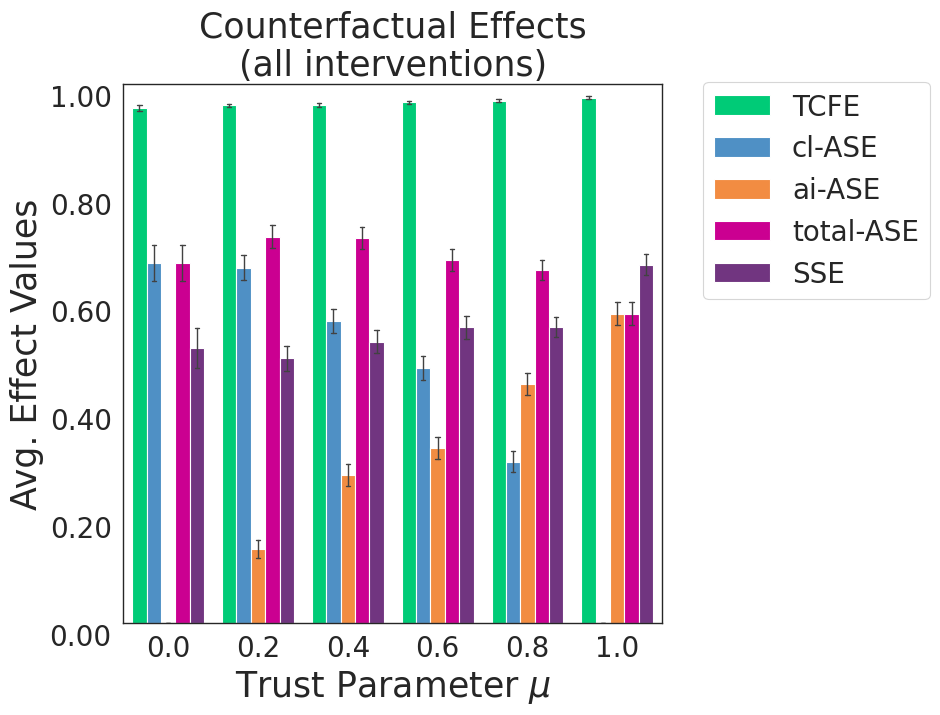

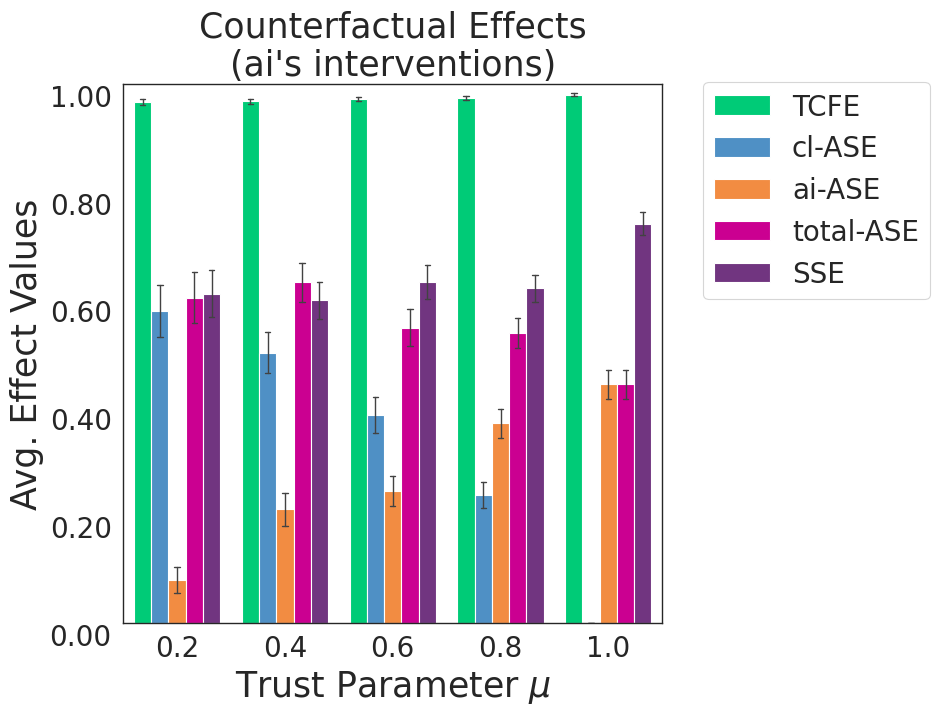

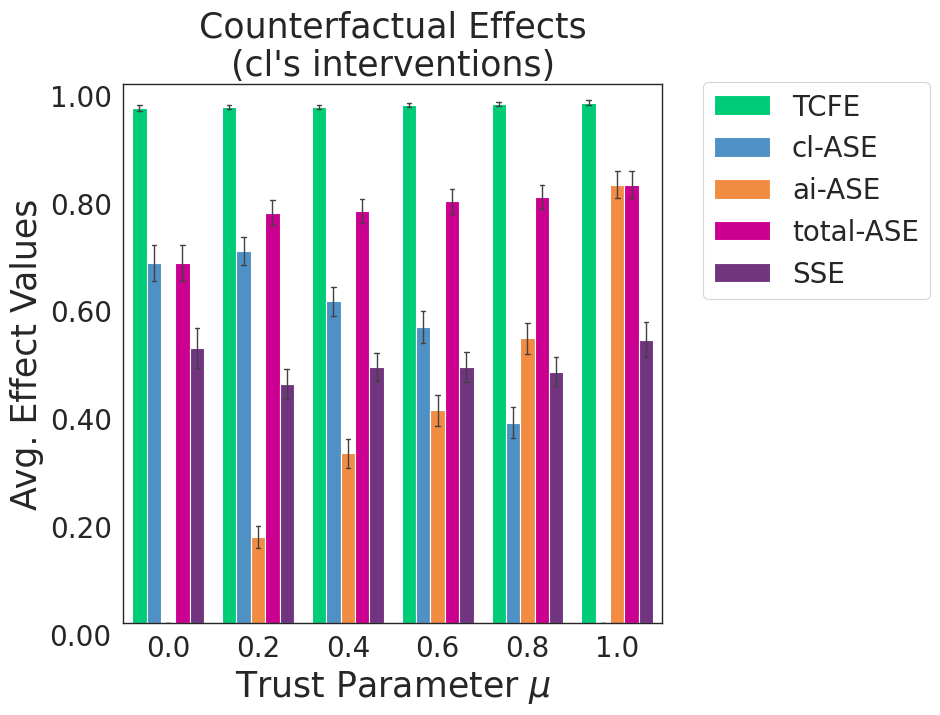

In [14]:
plt_effects(df_curr, title_suffix="\n(all interventions)", file_name="plt_effects_tcfe_ai-cl-total_ase_sse_all_interventions.pdf")
plt_effects(df_curr[df_curr.agent_id == 0], title_suffix="\n(ai's interventions)", file_name="plt_effects_tcfe_ai-cl-total_ase_sse_ai_interventions.pdf")
plt_effects(df_curr[df_curr.agent_id == 1], title_suffix="\n(cl's interventions)", file_name="plt_effects_tcfe_ai-cl-total_ase_sse_cl_interventions.pdf")

In [15]:
df = counterfactuals_w_quantities.copy()
df = df[df["total-ASE"] > 0.0] # avoid division by zero
discrepancy = abs(df["total-ASE"] - (df["cl-ASE"] + df["ai-ASE"])) / df["total-ASE"]
discrepancy.max()

95.0

## Showing TCFE, total-ASE, ASE-SV, (negative) reverse-SSE

In this section, we show values of TCFE, total-ASE, (negative) reverse-SSE as well as contribution scores calculated via ASE-Shapley Value (ASE-SV) method.

In [17]:
df_curr = counterfactuals_w_quantities.copy()
df_curr["-r-SSE"] = -1 * df_curr["r-SSE"]
df_curr = df_curr.drop(columns=["seed", "ai-ASE", "cl-ASE", "r-SSE", "SSE"])
df_curr = df_curr.rename(columns={"ase_sv_ai": "$\\phi_{ai}$", "ase_sv_cl": "$\\phi_{cl}$"})
df_curr = df_curr.melt(id_vars=["traj_id", "agent_id", "time_step", "alternative", "trust_level"])

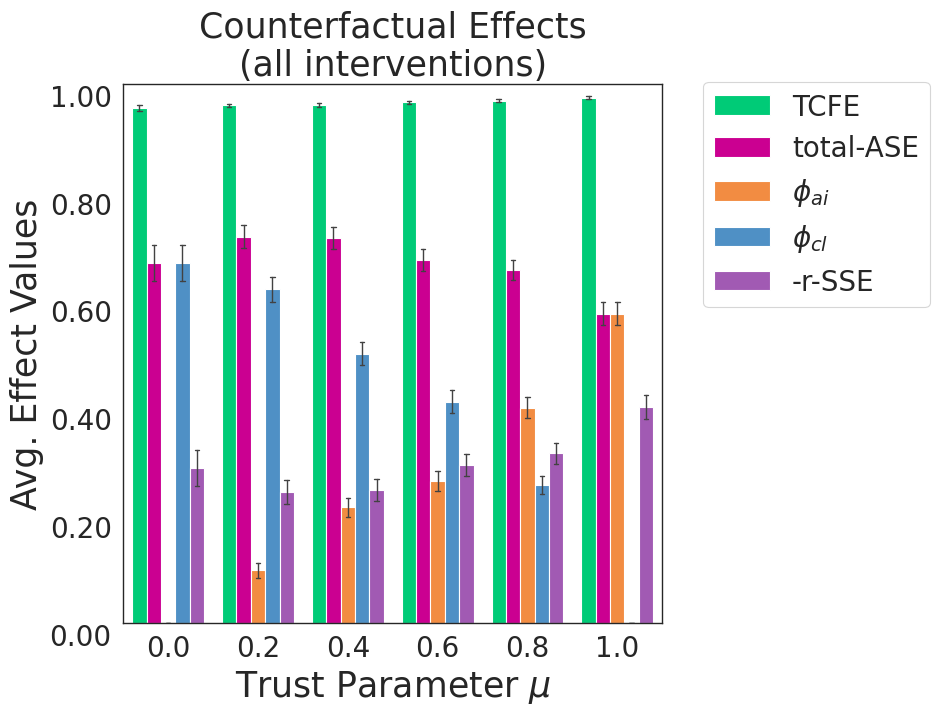

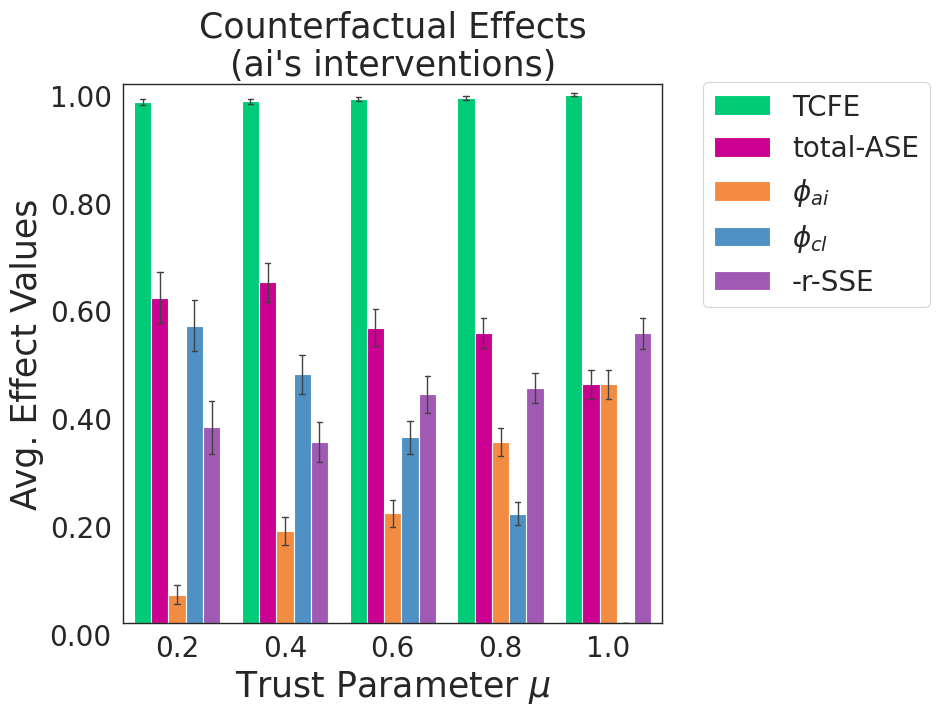

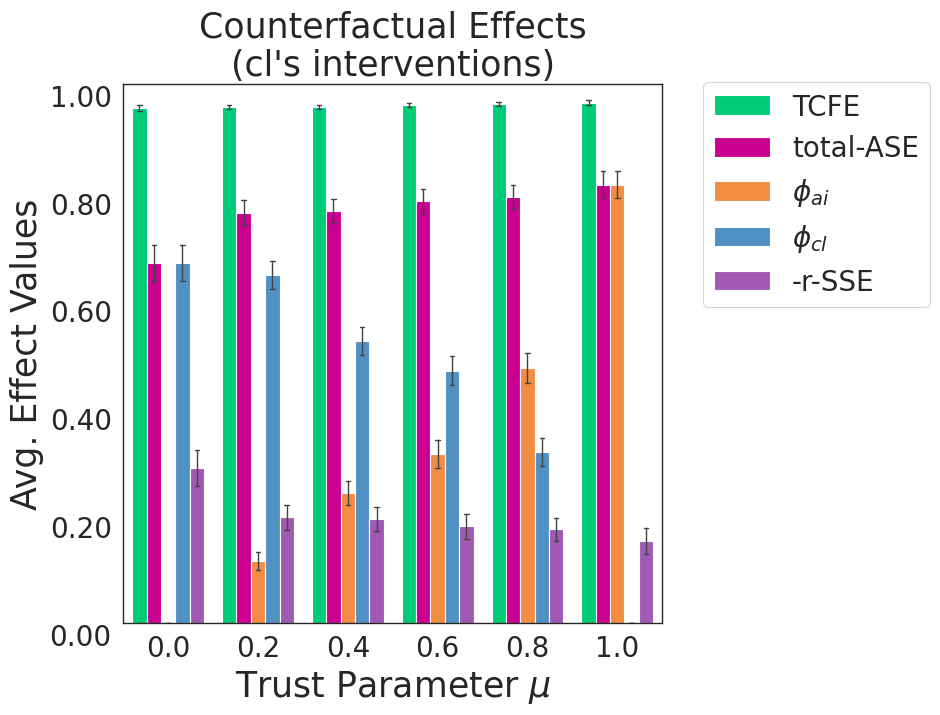

In [18]:
plt_effects(df_curr, title_suffix="\n(all interventions)", file_name="plt_effects_ase_sv_rsse_all_interventions.pdf")
plt_effects(df_curr[df_curr.agent_id == 0], title_suffix="\n(ai's interventions)", file_name="plt_effects_ase_sv_rsse_ai_interventions.pdf")
plt_effects(df_curr[df_curr.agent_id == 1], title_suffix="\n(cl's interventions)", file_name="plt_effects_ase_sv_rsse_cl_interventions.pdf")

## Showing Decomposition of TCFE into ASE-SV and (negative of) reverse SSE

In this section, we show the decomposition of TCFE into the contribution scores of the two actors, according to ASE-SV, and the (negative of) reverse SSE.

In [19]:
df_curr = counterfactuals_w_quantities.copy()

df_curr["-r-SSE"] = -1 * df_curr["r-SSE"] / df_curr["TCFE"]
df_curr["$\\phi_{ai}$"] = df_curr["ase_sv_ai"] / df_curr["TCFE"]
df_curr["$\\phi_{cl}$"] = df_curr["ase_sv_cl"] / df_curr["TCFE"]
assert np.allclose(df_curr["$\\phi_{ai}$"] + df_curr["$\\phi_{cl}$"] + df_curr["-r-SSE"], 1.0)

# we will first plot -r-SSE, then \phi_{cl} on top of it and finally \phi_{ai} on top of that to obtain the "stacked" bar-plot
df_curr.loc[:, "-r-SSE"] = 1.0
df_curr.loc[:, "$\\phi_{cl}$"] = df_curr.loc[:, "$\\phi_{ai}$"] + df_curr.loc[:, "$\\phi_{cl}$"]

df_curr = df_curr.drop(columns=["seed", "SSE", "TCFE", "ai-ASE", "cl-ASE", "total-ASE", "r-SSE", "ase_sv_ai", "ase_sv_cl", "time_step", "alternative"])
df_curr = df_curr.melt(id_vars=["traj_id", "agent_id", "trust_level"])
df_curr

,traj_id,agent_id,trust_level,variable,value
0,0,1,0.0,-r-SSE,1.0
1,0,1,0.0,-r-SSE,1.0
2,0,1,0.0,-r-SSE,1.0
3,0,1,0.0,-r-SSE,1.0
4,0,1,0.0,-r-SSE,1.0
...,...,...,...,...,...
26179,599,0,1.0,$\phi_{cl}$,0.0
26180,599,0,1.0,$\phi_{cl}$,0.0
26181,599,0,1.0,$\phi_{cl}$,0.0
26182,599,0,1.0,$\phi_{cl}$,0.0


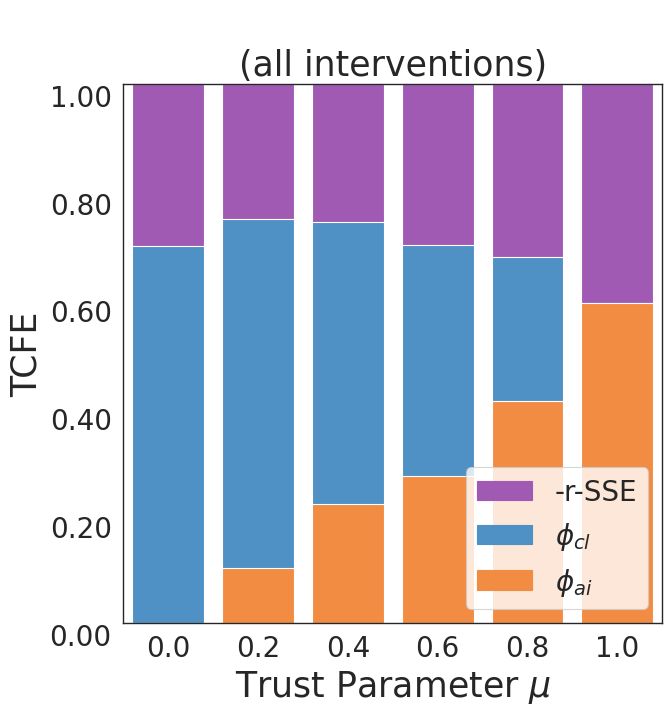

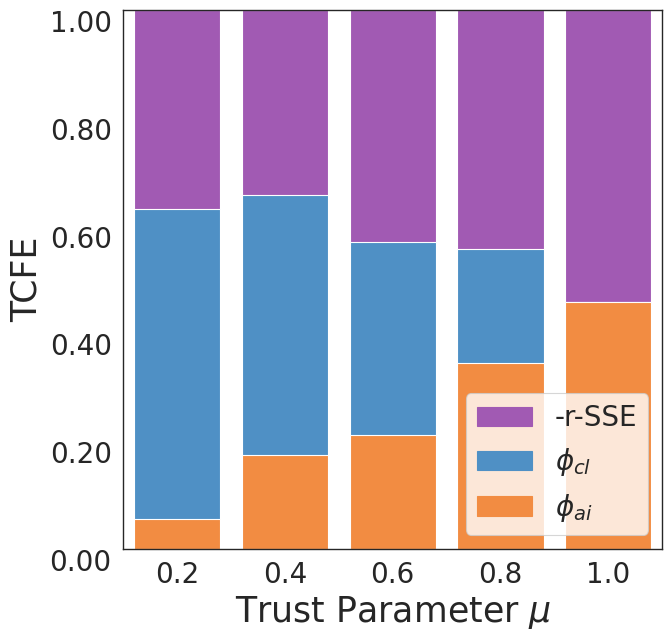

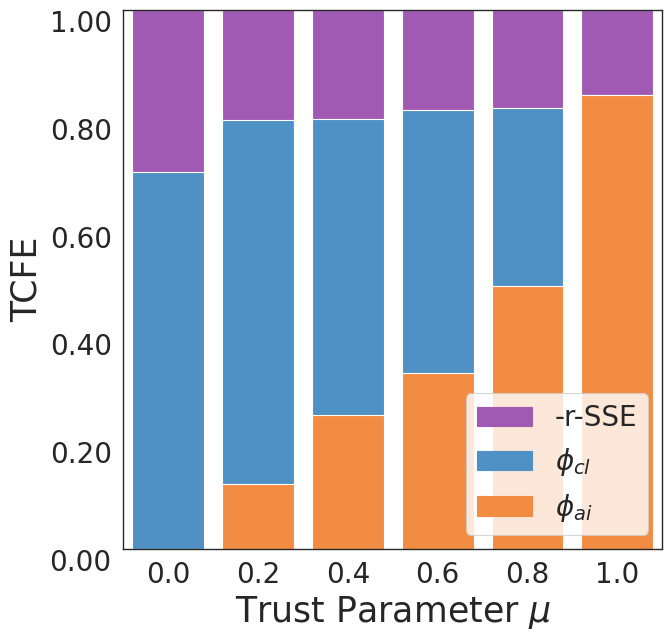

In [20]:
plt_percent_stacked_bar(df_curr, title_suffix="\n(all interventions)", file_name="plt_decomposition_all_interventions.pdf")
plt_percent_stacked_bar(df_curr[df_curr.agent_id == 0], title_suffix="", file_name="plt_decomposition_ai_interventions.pdf")
plt_percent_stacked_bar(df_curr[df_curr.agent_id == 1], title_suffix="", file_name="plt_decomposition_cl_interventions.pdf")

## Additional Results

To gain further insight into the relationship between different quantities, we showcase a data-frame containing some additional information.

In [21]:
df_curr = counterfactuals_w_quantities.copy()
df_curr = df_curr.drop(columns=["traj_id", "agent_id", "time_step", "alternative", "seed", "ase_sv_ai", "ase_sv_cl", "r-SSE"])
df_curr = df_curr.groupby("trust_level").mean().reset_index()

df_curr["total-ASE - (cl-ASE + ai-ASE)"] = df_curr["total-ASE"] - (df_curr["cl-ASE"] + df_curr["ai-ASE"])
df_curr["TCFE - (total-ASE + SSE)"] = df_curr["TCFE"] - (df_curr["total-ASE"] + df_curr["SSE"])

df_curr

,trust_level,TCFE,cl-ASE,ai-ASE,total-ASE,SSE,total-ASE - (cl-ASE + ai-ASE),TCFE - (total-ASE + SSE)
0,0.0,0.955913,0.667740,0.000000,0.667740,0.510470,0.000000,-0.222297
1,0.2,0.960156,0.658669,0.136878,0.716680,0.490608,-0.078866,-0.247132
2,0.4,0.961095,0.560379,0.274848,0.713895,0.521704,-0.121332,-0.274503
3,0.6,0.966181,0.472775,0.324825,0.673285,0.548402,-0.124316,-0.255506
4,0.8,0.969135,0.299285,0.443343,0.654773,0.549034,-0.087855,-0.234671
5,1.0,0.974456,0.000000,0.573798,0.573798,0.664744,0.000000,-0.264086


## Showing Frequency of Round Difference

In this part, we load the dataframe with the round difference column, which represents how many rounds before the final state of the trajectory the intervention happens (where each round consists of two consecutive time steps, during which first the AI and then the clinician take an action). After that, we display the distribution of round differences between the round at which the intervention occurred and the round at which the trajectory ends.

In [22]:
df_diff = pd.read_csv(results_dir / str(seed) / "total_rsse_variance.csv")
df_diff

,traj_id,agent_id,time_step,alternative,trust_level,tcfe,reverse_sse,round_diff,seed,total_rsse_variance
0,0,1,17,1,0.0,0.89,0.11,3,37130,0.069375
1,0,1,17,3,0.0,0.96,0.04,3,55020,0.024375
2,0,1,17,5,0.0,0.91,0.09,3,8080,0.047500
3,0,1,17,7,0.0,0.97,0.03,3,92464,0.000000
4,0,1,19,6,0.0,1.00,-1.00,2,47514,0.000000
...,...,...,...,...,...,...,...,...,...,...
8723,599,0,6,2,1.0,1.00,-1.00,1,30589,0.000000
8724,599,0,6,3,1.0,1.00,-1.00,1,8541,0.000000
8725,599,0,6,4,1.0,1.00,-1.00,1,69041,0.000000
8726,599,0,6,6,1.0,1.00,-1.00,1,69727,0.000000


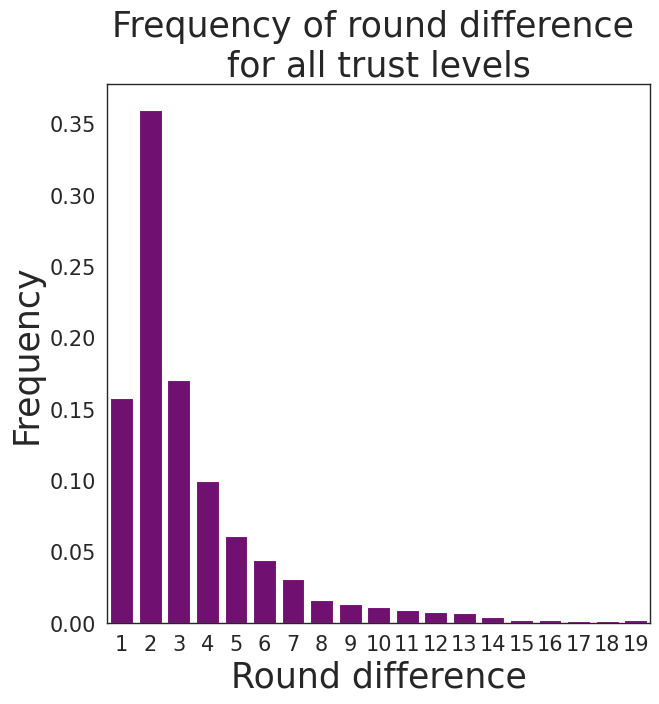

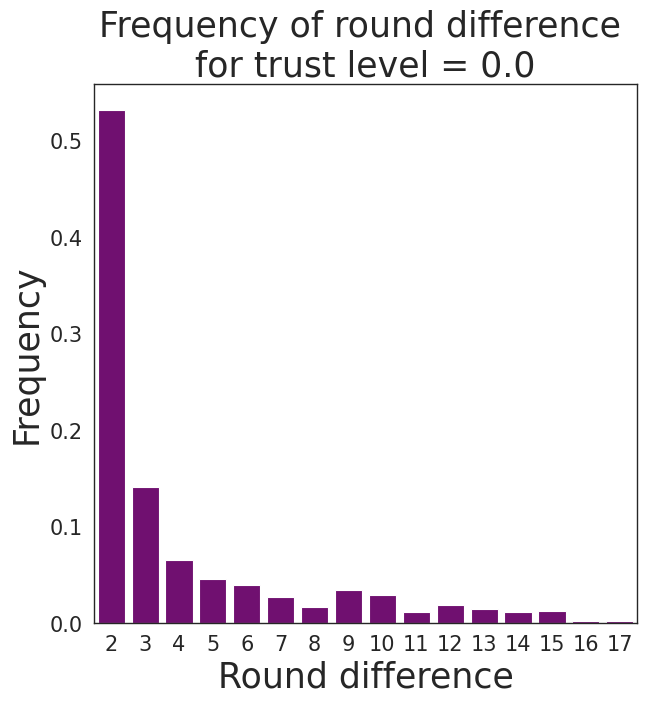

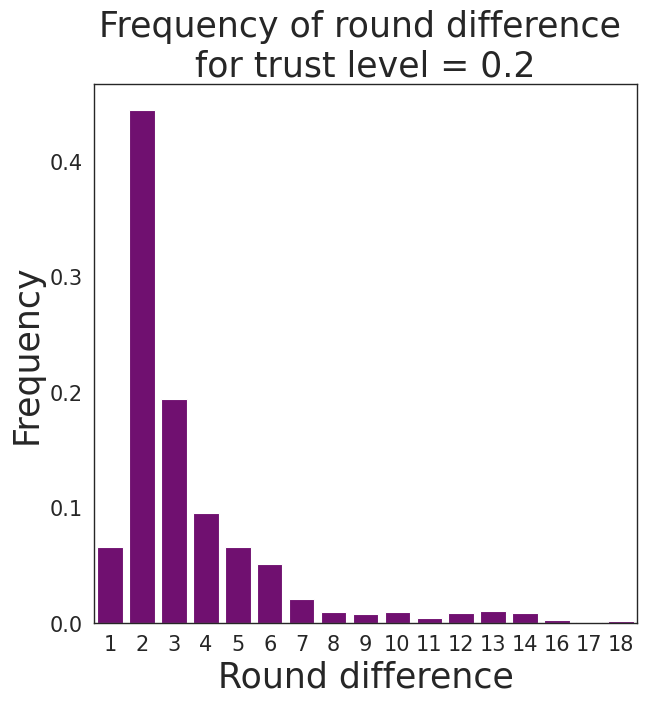

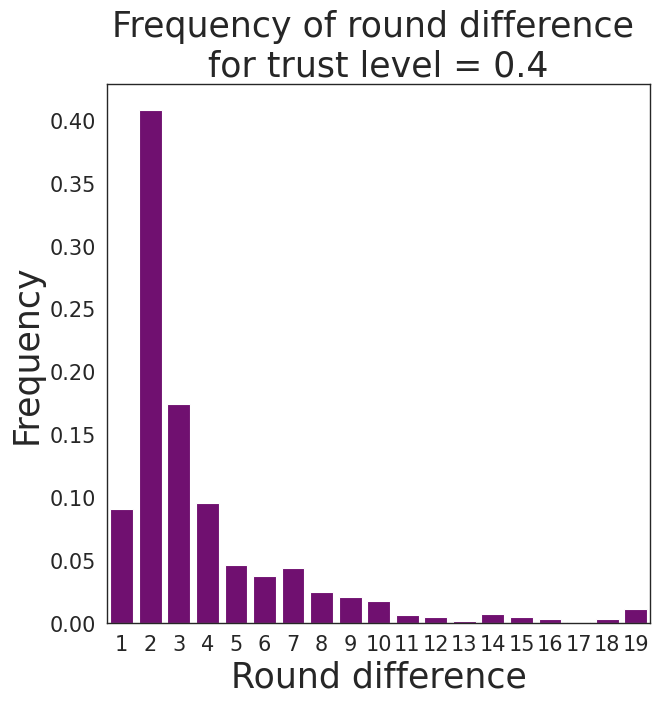

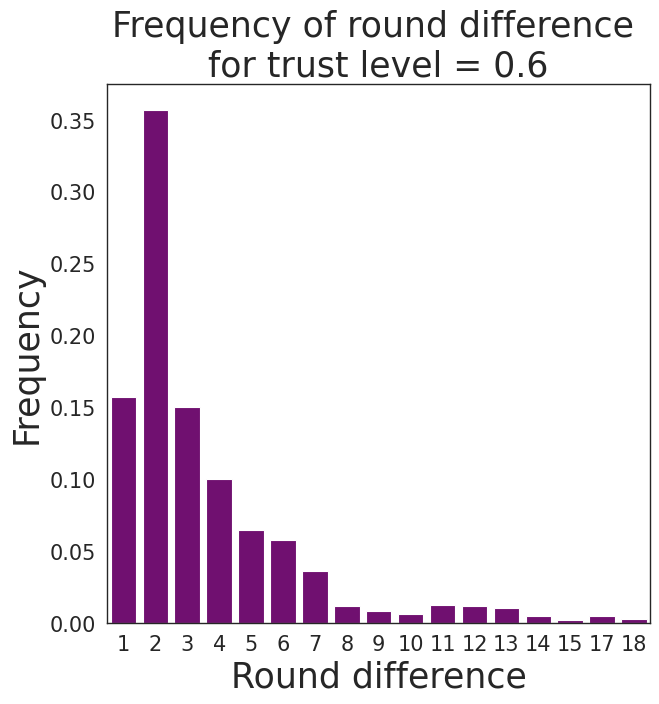

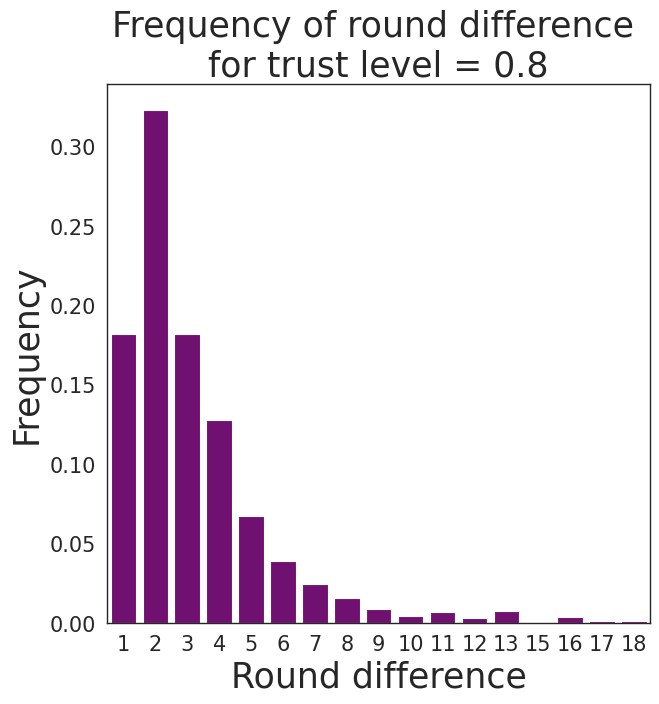

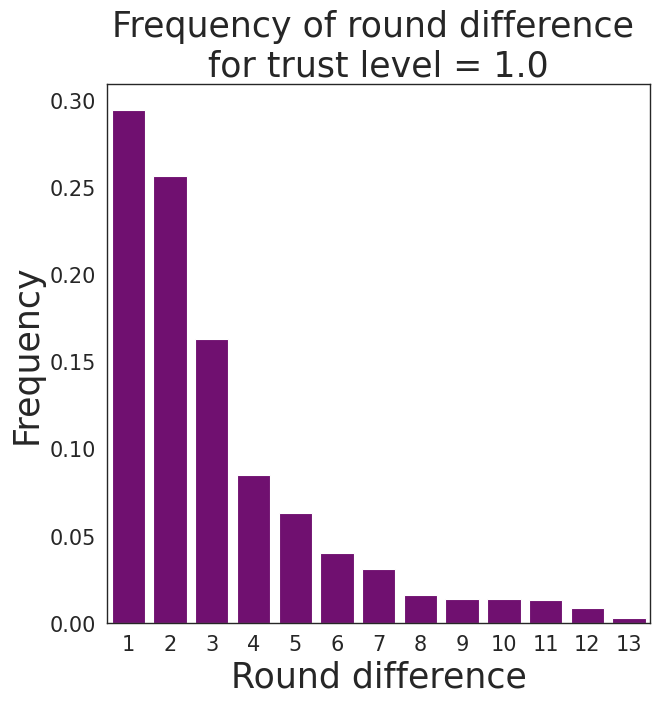

In [23]:
plt_round_diff(df_diff, title_suffix= "\nfor all trust levels")
for trust_level in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    plt_round_diff(df_diff[df_diff["trust_level"] == trust_level], title_suffix = f"\nfor trust level = {trust_level}")

### Save Frequency of Round Difference to File

In this section, we calculate the frequency and number of counterfactual trajectories for each round difference per trust level. Additionally, we determine the total number of counterfactual trajectories with a total counterfactual effect (TCFE) $\ge 0.8$ for each trust level. Then, we save the dataframe to "results/sepsis/{seed}/round_difference_count.csv".

In [24]:
def get_frequency_filtered_dataset(df:pd.DataFrame, rsse_threshold:int, variance_threshold:int):
    filtered_df = df.loc[np.where((abs(df.reverse_sse) >= rsse_threshold) & (df.total_rsse_variance >= variance_threshold))]
    df_filtered_rdiff_count =  pd.merge(filtered_df.groupby("trust_level")["round_diff"].value_counts(normalize=True).sort_index().reset_index(),
                                        filtered_df.groupby("trust_level")["round_diff"].value_counts(normalize=False).sort_index().reset_index(), 
                                        on = ["trust_level", "round_diff"], how="inner").rename(columns={"proportion" : "filtered_proportion", "count" : "filtered_count"})
    df_filtered_rdiff_count.loc[:, "filtered_trust_level_count"] = np.round(df_filtered_rdiff_count["filtered_count"] / df_filtered_rdiff_count["filtered_proportion"], 1).astype(int)
    return df_filtered_rdiff_count

In [25]:
# calculate frequency and count of different round differences for whole counterfactuals
df_rdiff_count =  pd.merge(df_diff.groupby("trust_level")["round_diff"].value_counts(normalize=True).sort_index().reset_index(),
                           df_diff.groupby("trust_level")["round_diff"].value_counts(normalize=False).sort_index().reset_index(), 
                           on = ["trust_level", "round_diff"], how="inner")
df_rdiff_count.loc[:, "trust_level_count"] = np.round(df_rdiff_count["count"] / df_rdiff_count["proportion"], 1).astype(int)

# calculate frequency and count of different round differences for counterfactuals with the values above the specified thresholds
df_filtered_rdiff_count =  get_frequency_filtered_dataset(df=df_diff, rsse_threshold=0.1, variance_threshold=0.01)

# merge two dataframes and save them
df_rdiff_count = pd.merge(df_rdiff_count, df_filtered_rdiff_count, on = ["trust_level", "round_diff"], how="left").fillna(0)
df_rdiff_count.to_csv(results_dir / str(seed) / "round_difference_count.csv", index=False)
df_rdiff_count

,trust_level,round_diff,proportion,count,trust_level_count,filtered_proportion,filtered_count,filtered_trust_level_count
0,0.0,2,0.531646,294,553,0.434483,63.0,145.0
1,0.0,3,0.141049,78,553,0.048276,7.0,145.0
2,0.0,4,0.065099,36,553,0.041379,6.0,145.0
3,0.0,5,0.045208,25,553,0.020690,3.0,145.0
4,0.0,6,0.039783,22,553,0.062069,9.0,145.0
...,...,...,...,...,...,...,...,...
94,1.0,9,0.013602,25,1838,0.020408,5.0,245.0
95,1.0,10,0.013602,25,1838,0.000000,0.0,0.0
96,1.0,11,0.013058,24,1838,0.008163,2.0,245.0
97,1.0,12,0.008705,16,1838,0.008163,2.0,245.0


## Plot Average reverse SSE Contribution Scores

In this part, we first load the contribution scores for the specified round difference. Then, we convert the scores' array from string to array format. We keep the scores' array starting from the round following the intervention for each array.

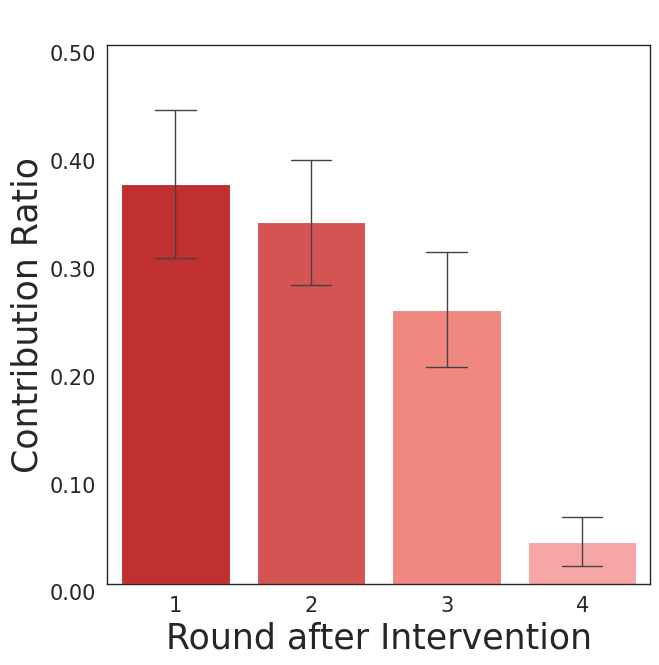

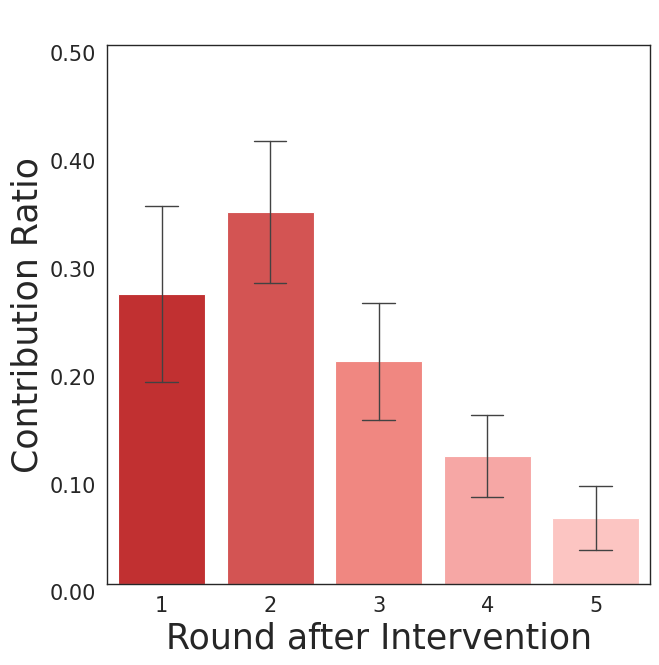

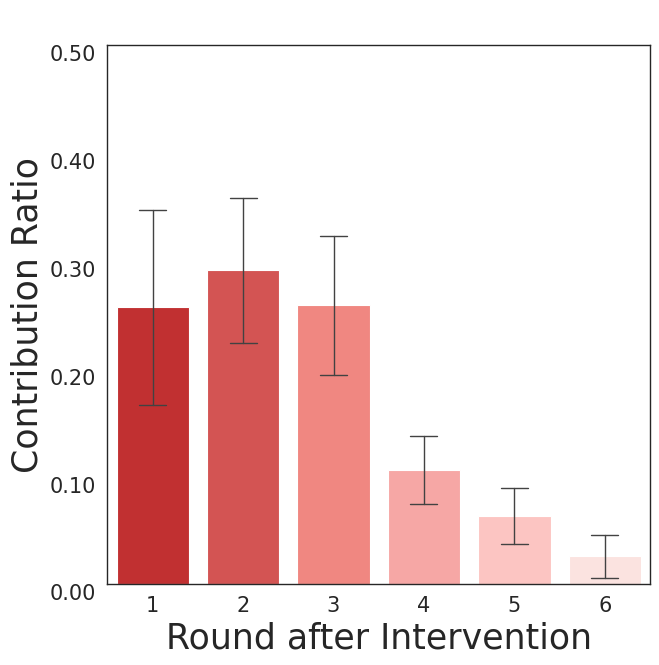

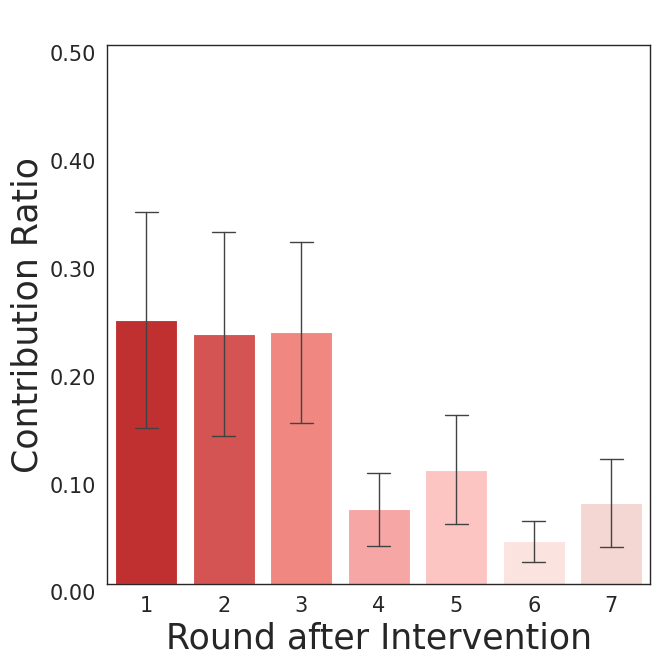

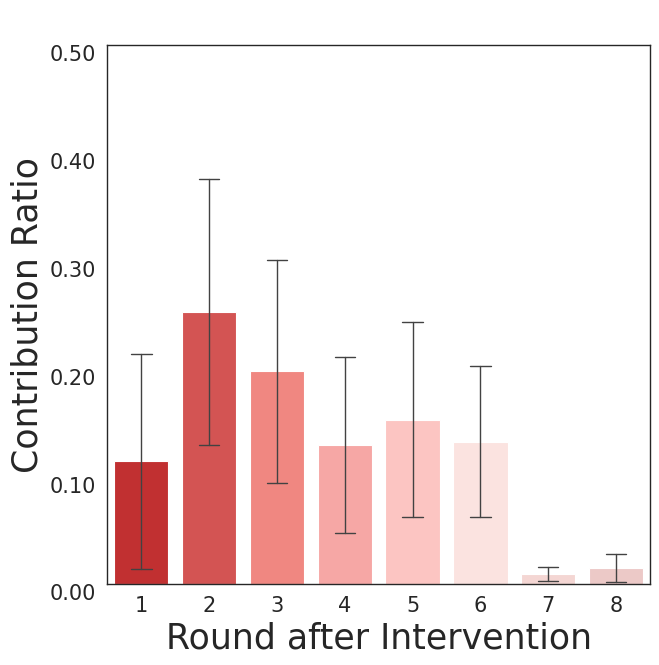

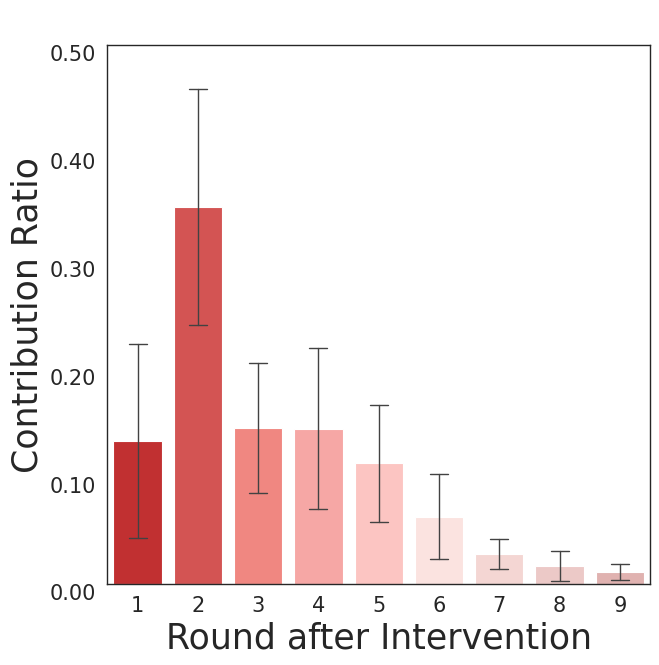

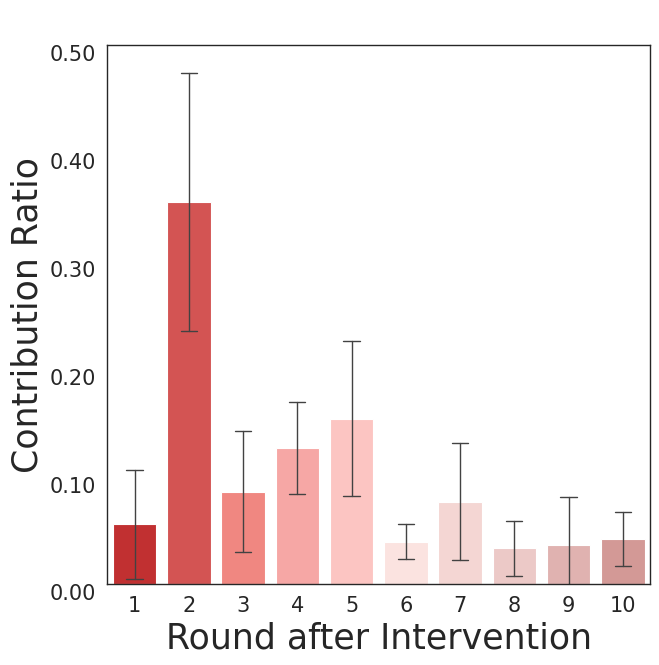

In [26]:
num_rounds = list(range(4, 11))
for n in num_rounds:
    # load contribution scores
    round_difference = n
    df_contribution_scores = pd.read_csv(results_dir / str(seed) / f"reverse_sse_contribution_scores{round_difference}.csv")
    df_contribution_scores.loc[:, "reverse_sse_contribution"] = df_contribution_scores.reverse_sse_contribution.apply(lambda arr: np.array([float(item) for item in arr[1:-1].split(",")]))
    df_contribution_scores = df_contribution_scores.loc[np.where(df_contribution_scores.reverse_sse_contribution.apply(lambda arr: any(np.array(arr) != 0)))].reset_index(drop=True)
    df_contribution_scores.loc[:, "reverse_sse_contribution"] = df_contribution_scores.apply(lambda row: row.reverse_sse_contribution[(row.time_step//2 + 1)*2:], axis=1)
    df_contribution_scores.loc[:, "rsse_contribution_ratio"] = df_contribution_scores.reverse_sse_contribution / df_contribution_scores.reverse_sse
    
    # filter out counterfactuals with negative scores
    l = len(df_contribution_scores)
    df_contribution_scores = df_contribution_scores[df_contribution_scores['rsse_contribution_ratio'].apply(lambda x: np.all(np.array(x) >= 0))].reset_index(drop=True)
    
    # plot avg. scores
    plt_avg_rsse_contribution(df_contribution_scores, file_name=f"reverse_sse_contribution_scores_r{round_difference}.pdf")

## Plot Gini Coefficient Distribution

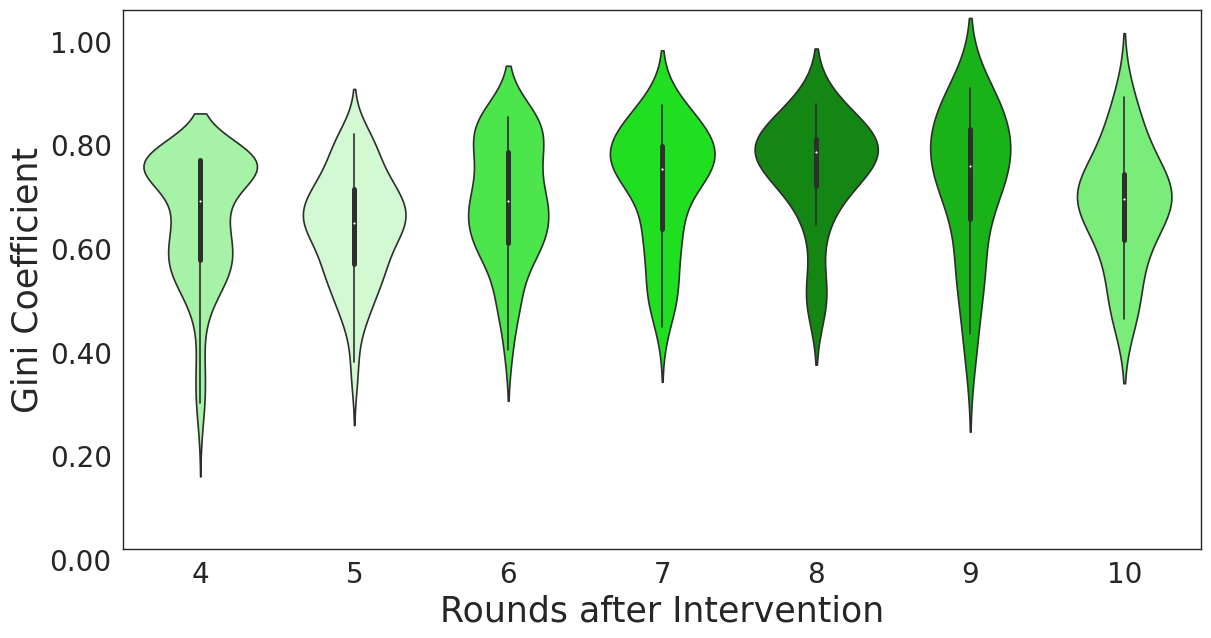

In [27]:
gini_scores = {}
for n in num_rounds:
    # load contribution scores
    round_difference = n
    df_contribution_scores = pd.read_csv(results_dir / str(seed) / f"reverse_sse_contribution_scores{round_difference}.csv")
    df_contribution_scores.loc[:, "reverse_sse_contribution"] = df_contribution_scores.reverse_sse_contribution.apply(lambda arr: np.array([float(item) for item in arr[1:-1].split(",")]))
    df_contribution_scores = df_contribution_scores.loc[np.where(df_contribution_scores.reverse_sse_contribution.apply(lambda arr: any(np.array(arr) != 0)))].reset_index(drop=True)
    df_contribution_scores.loc[:, "reverse_sse_contribution"] = df_contribution_scores.apply(lambda row: row.reverse_sse_contribution[(row.time_step//2 + 1)*2::2], axis=1)
    df_contribution_scores.loc[:, "rsse_contribution_ratio"] = df_contribution_scores.reverse_sse_contribution / df_contribution_scores.reverse_sse
    # filter out counterfactuals with negative r-SSE-ICC scores -- this is due to the finite number of samples
    l = len(df_contribution_scores)
    df_contribution_scores = df_contribution_scores[df_contribution_scores["rsse_contribution_ratio"].apply(lambda x: np.all(np.array(x) >= 0))].reset_index(drop=True)
    # compute gini scores
    gini_scores[f"{n}"] = df_contribution_scores["rsse_contribution_ratio"].apply(gini)
plt_violin_gini(gini_scores)